In [ ]:
#upload api key
from google.colab import files
files.upload()

# prepare for api command and give permission for read and write
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!rm -rf kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# apply Api command
!kaggle datasets download -d jangedoo/utkface-new

#unzip dataset
!unzip /content/utkface-new.zip &> /dev/null
!rm -rf /content/utkface-new.zip

Saving kaggle.json to kaggle.json
 99% 329M/331M [00:15<00:00, 23.1MB/s]
100% 331M/331M [00:15<00:00, 22.5MB/s]


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
age=[]
gender=[]
image_path=[]

for dirname, _, filenames in os.walk('/content/UTKFace'):
    for filename in filenames:
          age.append(int(filename.split("_")[0]))
          gender.append(int(filename.split("_")[1]))
          image_path.append(os.path.join(dirname,filename))

df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age, gender
df.head()

,image,age,gender
0,/content/UTKFace/50_0_0_20170104170550929.jpg....,50,0
1,/content/UTKFace/23_1_3_20170119164040174.jpg....,23,1
2,/content/UTKFace/35_0_1_20170113133712152.jpg....,35,0
3,/content/UTKFace/44_0_1_20170117172143700.jpg....,44,0
4,/content/UTKFace/26_1_3_20170119192325721.jpg....,26,1


In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from PIL import Image

In [ ]:
def extract_features (image):
  features = []
  for i in image:
    img = tf.keras.utils.load_img(i,color_mode = "grayscale")
    img = img.resize((128,128),Image.ANTIALIAS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  # ignore this step if using RGB
  features = features.reshape(len(features), 128, 128, 1)
  return features

In [ ]:
x = extract_features(df['image'])
# normalize the images
X  = x/255.0
# target variable
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])



/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
input_shape = (128, 128, 1)

# Model Creation
inputs = Input((input_shape))
# convolutional layers

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)
dense_1 = Dense(128, activation='relu') (dense_1)
dense_2 = Dense(128, activation='relu') (dense_2)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

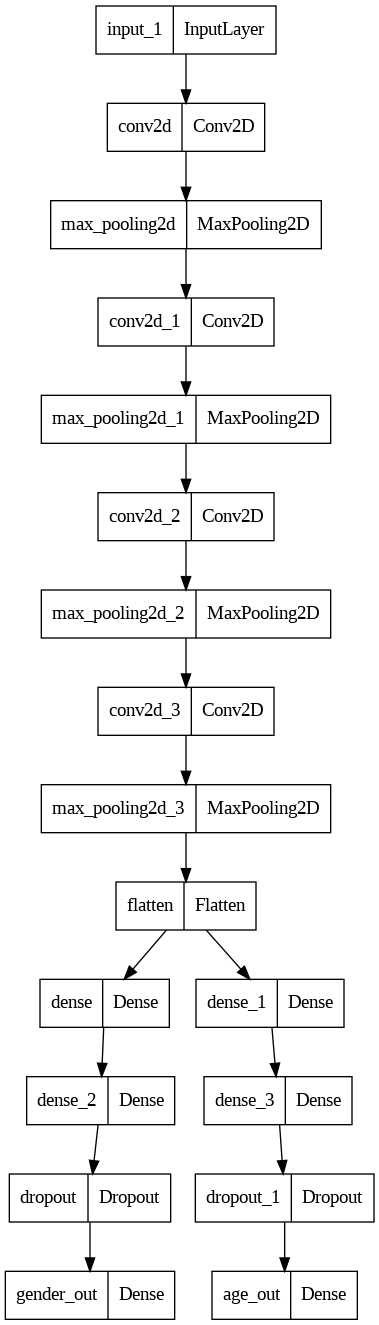

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=20, validation_split=0.2)

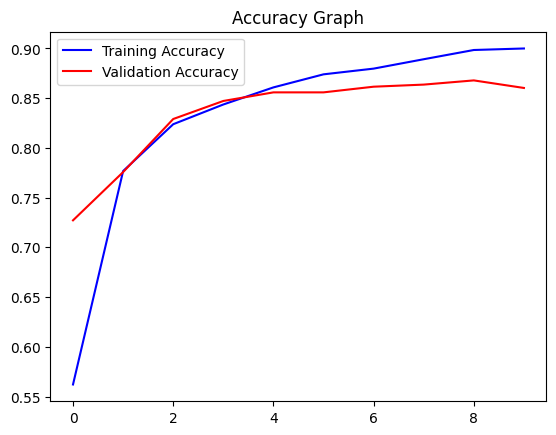

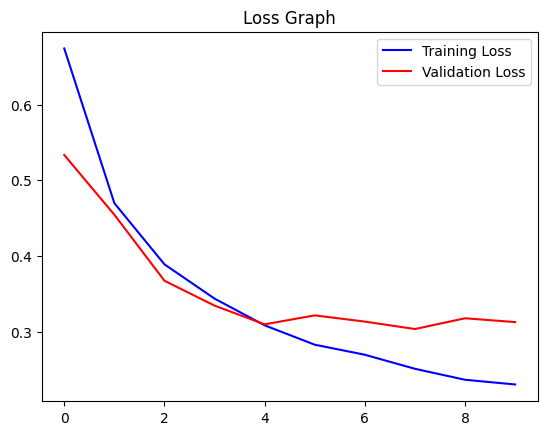

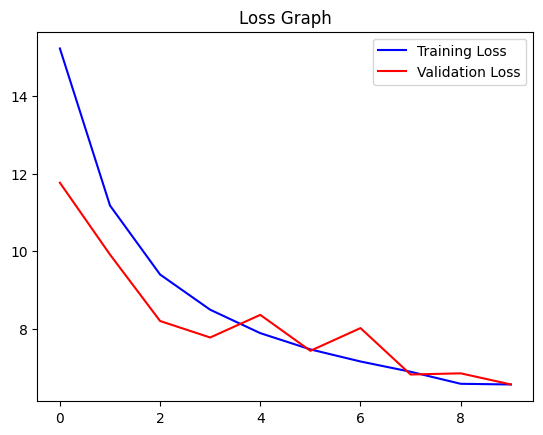

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()




# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()



Original Gender: Female Original Age: 58
1/1 [==============================] - 0s 26ms/step
Predicted Gender: Female Predicted Age: 51


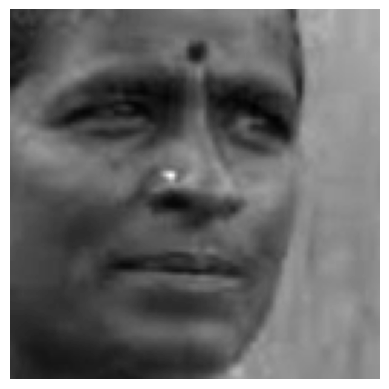

In [ ]:
# Test the model
image_index = 900
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
model.save("agemodel.h5")

In [ ]:
from google.colab import drive
drive.mount("mydrive")

Mounted at mydrive


In [ ]:
!cp /content/agemodel.h5 /content/mydrive/MyDrive